In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-multilearn==0.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 9.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf

# Disable GPU (if available)
tf.config.set_visible_devices([], 'GPU')

# Or, you can specify the CPU device explicitly
# tf.config.set_visible_devices([], 'GPU:0')

# Now TensorFlow will use only the CPU

In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.adapt import MLkNN
import sklearn.metrics as metrics
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix
import os

In [27]:
os.chdir('/content/drive/MyDrive/NLP_Project/NLP/training')
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content/drive/.shortcut-targets-by-id/1_CDY8Dm7L5Tja0e9ZZ13F9diyKUaPn_n/NLP_Project/NLP/training': ['train_en_l1.csv', 'train_en_l2.csv', 'train_en_l3.csv', 'train_hi_l1.csv', 'train_hi_l2.csv', 'train_hi_l3.csv', 'train_ta_l1.csv', 'train_ta_l2.csv', 'train_ta_l3.csv']


In [28]:
# d2 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')
# d2 = d2.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
# d2['Label'] = d2['Label'].astype(int)
# d2 = d2[['Label', 'text']]
# d2

In [29]:
# d2 = pd.read_csv('train_ta_l1_modded.csv')
d1 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l1.csv')
d2 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l2.csv')
d3 = pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/training/train_ta_l3.csv')

# Convert the relevant columns to numeric before applying max
for col in ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']:
    d1[col] = pd.to_numeric(d1[col], errors='coerce')  # errors='coerce' to handle non-numeric values
    d2[col] = pd.to_numeric(d2[col], errors='coerce')  # errors='coerce' to handle non-numeric values
    d3[col] = pd.to_numeric(d3[col], errors='coerce')  # errors='coerce' to handle non-numeric values

d1['label'] = d1[['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d1 = d1.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
d1['label'] = d1['label'].astype(int)
d1 = d1[['label', 'text']]
d1

d2['label'] = d2[['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d2 = d2.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
d2['label'] = d2['label'].astype(int)
d2 = d2[['label', 'text']]
d2

d3['label'] = d3[['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

d3 = d3.drop(['key', 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'], axis=1)
d3['label'] = d3['label'].astype(int)
d3 = d3[['label', 'text']]
d3


,label,text
0,0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆
4,1,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...
...,...,...
6774,1,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭
6775,0,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமை...
6776,0,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...
6777,1,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...


The label column is created in the original training dataset by taking the majority occurence of 0 or 1 among all the 6 annotators in columns - 'ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6'.

In [30]:
d1.rename(columns = {'Label':'label'}, inplace = True)
d1
d2.rename(columns = {'Label':'label'}, inplace = True)
d2
d3.rename(columns = {'Label':'label'}, inplace = True)
d3

,label,text
0,0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆
4,1,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...
...,...,...
6774,1,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭
6775,0,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமை...
6776,0,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...
6777,1,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...


In [31]:
df1=d1
df2=d3
df3=d3

df1
df2
df3

,label,text
0,0,*1. முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் 😆
4,1,என்ன உடம்பு டா சாமி- சும்மா வளுவளுனு.. முலை ...
...,...,...
6774,1,😭😭😭 ஒம்மாள படிக்கல் புண்ட 😭😭😭
6775,0,🙄🙄🙄🙄 என்ன எழவுயா இது... இதெல்லாம் ஒரு பெருமை...
6776,0,🚨எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ள...
6777,1,🤣 🤣 சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்...


## Word Pre-Processing

In [32]:
## Word Pre-Processing ##
import nltk
import string
import re

## Function to normalize text for pre-processing ##
def normalize_text(text):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F700-\U0001F77F"  # alchemical symbols
                              u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                              u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                              u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                              u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                              u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                              u"\U00002702-\U000027B0"  # Dingbats
                              u"\U000024C2-\U0001F251"
                              "]+", flags=re.UNICODE)
  text = text.lower()
  text = re.sub('\[.*?\]', ' ', text)
  text = re.sub('https?://\S+|www\.\S+', ' ', text)
  text = re.sub('<.*?>+', ' ', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  text = re.sub('\n', ' ', text)
  text = re.sub('\w*\d\w*', ' ', text)
  text = re.sub('<handle replaced>', '', text)
  text = emoji_pattern.sub(r'', text)
  return text


In [33]:
## Apply the written function ##
df1['text'] = df1['text'].apply(lambda x: normalize_text(x))
df1
df2['text'] = df2['text'].apply(lambda x: normalize_text(x))
df2
df3['text'] = df3['text'].apply(lambda x: normalize_text(x))
df3

,label,text
0,0,முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி...
1,1,சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக...
2,0,தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா
3,1,பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும்
4,1,என்ன உடம்பு டா சாமி சும்மா வளுவளுனு முலை ...
...,...,...
6774,1,ஒம்மாள படிக்கல் புண்ட
6775,0,என்ன எழவுயா இது இதெல்லாம் ஒரு பெருமைனு ந...
6776,0,எக்ஸ் பிரஸ் பேர்ல் கப்பல் தீ விபத்துக்கு உள்ளா...
6777,1,சல்லி ஜாதி வெறி முட்டா புண்ட உங்க பொண்ணுங்க ...


# Train Test Splits

In [34]:
X1 = list(df1['text'])
#y = np.asarray(d1[d1.columns[1:]])
y_data1 = df1['label']
y1 = y_data1.values

X2 = list(df2['text'])
#y = np.asarray(d2[d2.columns[2:]])
y_data2 = df2['label']
y2 = y_data2.values

X3 = list(df3['text'])
#y = np.asarray(d3[d3.columns[3:]])
y_data3 = df3['label']
y3 = y_data3.values

In [35]:
len(X1)
len(X2)
len(X3)

6779

In [36]:
y1.size
y2.size
y2.size

6779

In [37]:
X1
X2
X3

['       முரசொலி அலுவலகம் அமைந்துள்ள இடம் பஞ்சமி நிலம் இல்லை என்பதை நிரூபிக்க   ஆம் ஆண்டு வாங்கப்பட்ட பட்டாவை ஆதாரமாகக் காட்டியிருக்கிறார் மு க ஸ்டாலின்   இதற்கு காட்ட வேண்டிய     ',
 '   சோத்துக்கு பிச்சை எடுக்கிற கடங்கார நாய்களுக்கு பேச்சு புண்டையை  பாரு     போய் சீனா காரனுக்கு சூத்து குடு போ',
 '   தத்தபுத்த தத்தபுத்த ன்னு எதாவது புரியுதா',
 '   பச்சை மொளகா காரம் vicky அம்மா புண்டை நாறும் ',
 '  என்ன உடம்பு டா சாமி  சும்மா வளுவளுனு   முலை ஒவ்வொன்னும் தேங்காய் போல   நடிகை மாளவிகாவின் லேட்டஸ்ட் போட்டோஷூட்',
 '  கதற விட்ட புலம் பெயர் உறவுகள் கதி கலங்கி போன கோத்தா பையன்',
 '  பத்தினி வேச பு   வேற எடத்துல காட்டு இங்குட்டு ஒரு உருட்டு அங்குட்டு நல்லவன் வேசம் ஆ மூடிட்டு போடா மயிரு   \u200d',
 '  உன்னைய தூக்கி போட்டு நா ஓக்க   ',
 ' ஆடு திருடுனதுக்கு எப்பிடியும் தண்டனை கிடைச்சிரும்னு பயந்து ஆட்டைக்கூட ஒளிச்சி வச்சிட்டேன்          அப்புறம்         பக்கத்து தெருவுல கோழி திருடுனவனை ஏன் கைது செய்யலைன்னு சொல்லி ஜட்ஜய்யா என்னை விடுதலை செஞ்சிட்டாரு          ',
 ' ஊரடங்கால்   கோடிக்கு மேல் இழப்பு  

In [38]:
y1
y2
y3

array([0, 1, 0, ..., 0, 1, 1])

# Model RNN

In [39]:
#Model CNN & Bi-LSTM
# Model CNN & Bi-LSTM
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Flatten, Bidirectional, GRU, concatenate, SpatialDropout1D
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
######## Textual Features for Embedding ###################
# max_len = 100
# max_features = 10000
# embed_size = 300
# tokenizer = Tokenizer(num_words=max_features)
# tokenizer.fit_on_texts(list(X))
# X = tokenizer.texts_to_sequences(X)
# X = pad_sequences(X, padding='post', maxlen=max_len)

# Define model parameters
max_seq_length = 100  # Maximum sequence length for input posts (up to 70 words)
max_features = 33064
embed_size = 300
# Load pre-trained fastText Bengali embeddings
embedding_dim = 300  # Dimensionality of word embeddings
embedding_path = '/content/drive/MyDrive/NLP_Project/NLP/cc.ta.300.vec'

# Tokenization
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(list(X1))
word_index = tokenizer.word_index
X1 = tokenizer.texts_to_sequences(X1)
X1 = pad_sequences(X1, padding='post', maxlen=max_seq_length)

tokenizer.fit_on_texts(list(X2))
word_index = tokenizer.word_index
X2 = tokenizer.texts_to_sequences(X2)
X2 = pad_sequences(X2, padding='post', maxlen=max_seq_length)

tokenizer.fit_on_texts(list(X3))
word_index = tokenizer.word_index
X3 = tokenizer.texts_to_sequences(X3)
X3 = pad_sequences(X3, padding='post', maxlen=max_seq_length)

In [40]:
y1
y2
y3

array([0, 1, 0, ..., 0, 1, 1])

In [41]:
X1
X2
X3

array([[ 1557,  2466,  5573, ...,     0,     0,     0],
       [ 1396,   323,  5574, ...,     0,     0,     0],
       [ 5575,  5575,   135, ...,     0,     0,     0],
       ...,
       [ 8512,  3879,  8513, ...,     0,     0,     0],
       [  406,   430,   602, ...,     0,     0,     0],
       [    4,   850, 33055, ...,     0,     0,     0]], dtype=int32)

In [42]:
# y

In [43]:
from keras.utils import to_categorical
y1 = to_categorical(y1, num_classes=2)
y2 = to_categorical(y2, num_classes=2)
y3 = to_categorical(y3, num_classes=2)
y1
y2
y3

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

In [44]:
# Read the pre-trained embedding vectors from .vec file
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
with open(embedding_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().split()
        word = values[0]
        if word in word_index:
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_matrix[word_index[word]] = coefs

# Model Training

In [47]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall, AUC


n_splits = 2
num_classes = 2
epochs = 10
batch_size = 32


def fn(X,y):
  X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2, random_state=None)
  model1 = Sequential([
      Embedding(input_dim=embedding_matrix.shape[0],
                output_dim=embed_size,
                weights=[embedding_matrix],
                trainable=False),  # Freeze embedding layer
      SimpleRNN(256),  # Basic LSTM layer with 64 units
      Dense(1024, activation='relu'),  # Fully connected layer
      Dense(num_classes, activation="softmax")  # Output layer
  ])
  model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

  history1 = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=epochs, batch_size=batch_size, verbose=1)

  # Evaluate model
  y_pred1 = np.argmax(model1.predict(X_val1), axis=1)
  y_val_labels1 = np.argmax(y_val1, axis=1)
  print(classification_report(y_val_labels1, y_pred1, target_names=["Hate", "Not Hate"]))


  # Calculate the average precision, recall, and f1-score across all folds
  # average_precision = np.mean(precision_list)
  # average_recall = np.mean(recall_list)
  # average_f1_score = np.mean(f1_score_list)
  return history1, model1, y_val_labels1, y_pred1

history_1, model_1, y_val_labels_1, y_pred_labels_1=fn(X1,y1)

# Display the average classification report
# average_report_1 = f'Average Precision: {average_precision_1:.2f}\nAverage Recall: {average_recall_1:.2f}\nAverage F1-Score: {average_f1_score_1:.2f}'
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report_1}')

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 36s 189ms/step - accuracy: 0.6439 - loss: 0.6311 - precision: 0.6439 - recall: 0.6439 - val_accuracy: 0.7087 - val_loss: 0.5780 - val_precision: 0.7087 - val_recall: 0.7087
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - accuracy: 0.7042 - loss: 0.5747 - precision: 0.7042 - recall: 0.7042 - val_accuracy: 0.7043 - val_loss: 0.5671 - val_precision: 0.7043 - val_recall: 0.7043
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 33s 111ms/step - accuracy: 0.7085 - loss: 0.5869 - precision: 0.7085 - recall: 0.7085 - val_accuracy: 0.7286 - val_loss: 0.5858 - val_precision: 0.7286 - val_recall: 0.7286
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.7180 - loss: 0.5595 - precision: 0.7180 - recall: 0.7180 - val_accuracy: 0.7367 - val_loss: 0.5355 - val_precision: 0.7367 - val_recall: 0.7367
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.7399 - loss: 0.5325 - precision: 0.7399 - recall: 0.7399 - val_accuracy: 0.7242

In [48]:
model_1.save('/content/drive/MyDrive/NLP_Project/NLP/RNN_ICON_l1_Tamil_Binary_Classification.h5')

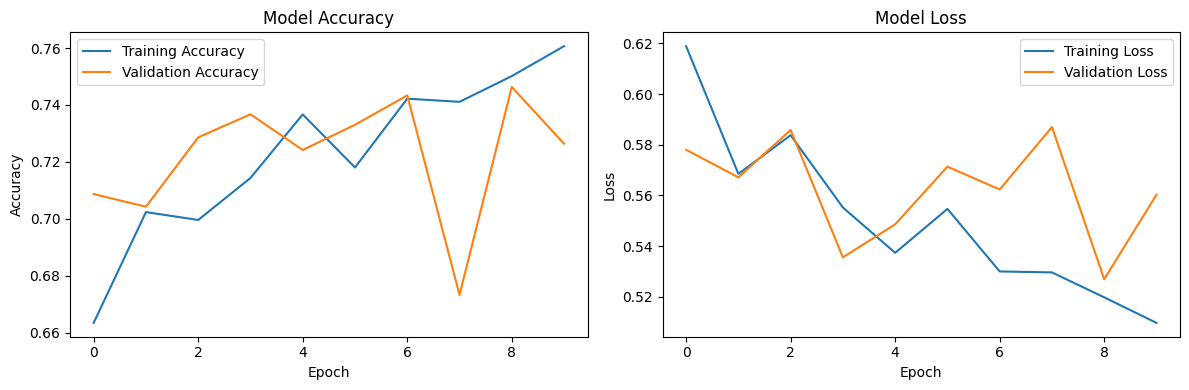

In [49]:
# Assuming you have trained your model and have a `history` object
# after fitting the model

import matplotlib.pyplot as plt

def plots(history):
  # Plot accuracy and loss graphs
  plt.figure(figsize=(12, 4))

  # Plot accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

plots(history_1)

In [50]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1_1 = f1_score(y_val_labels_1, y_pred_labels_1, average='weighted')
precision_1 = precision_score(y_val_labels_1, y_pred_labels_1, average='weighted')
recall_1 = recall_score(y_val_labels_1, y_pred_labels_1, average='weighted')

print(f'F1 Score: {f1_1}')
print(f'Precision: {precision_1}')
print(f'Recall: {recall_1}')
# print(report_1)

F1 Score: 0.720862358965313
Precision: 0.7790893419464048
Recall: 0.726401179941003


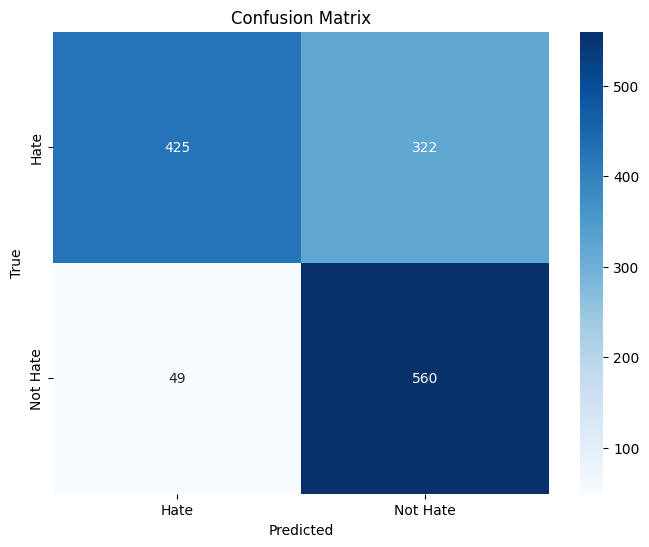

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix_1 = confusion_matrix(y_val_labels_1, y_pred_labels_1)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
history_2, model_2, y_val_labels_2, y_pred_labels_2=fn(X2,y2)
# Display the average classification report
# average_report_2 = f'Average Precision: {average_precision_2:.2f}\nAverage Recall: {average_recall_2:.2f}\nAverage F1-Score: {average_f1_score_2:.2f}'
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report_2}')

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 28s 121ms/step - accuracy: 0.6478 - loss: 0.6192 - precision: 0.6478 - recall: 0.6478 - val_accuracy: 0.7375 - val_loss: 0.5654 - val_precision: 0.7375 - val_recall: 0.7375
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.7202 - loss: 0.5523 - precision: 0.7202 - recall: 0.7202 - val_accuracy: 0.7345 - val_loss: 0.5581 - val_precision: 0.7345 - val_recall: 0.7345
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.7422 - loss: 0.5182 - precision: 0.7422 - recall: 0.7422 - val_accuracy: 0.7485 - val_loss: 0.5290 - val_precision: 0.7485 - val_recall: 0.7485
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.7451 - loss: 0.5161 - precision: 0.7451 - recall: 0.7451 - val_accuracy: 0.7522 - val_loss: 0.5482 - val_precision: 0.7522 - val_recall: 0.7522
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.7288 - loss: 0.5443 - precision: 0.7288 - recall: 0.7288 - val_accuracy: 0.6969

In [53]:
model_2.save('/content/drive/MyDrive/NLP_Project/NLP/RNN_ICON_l2_Tamil_Binary_Classification.h5')

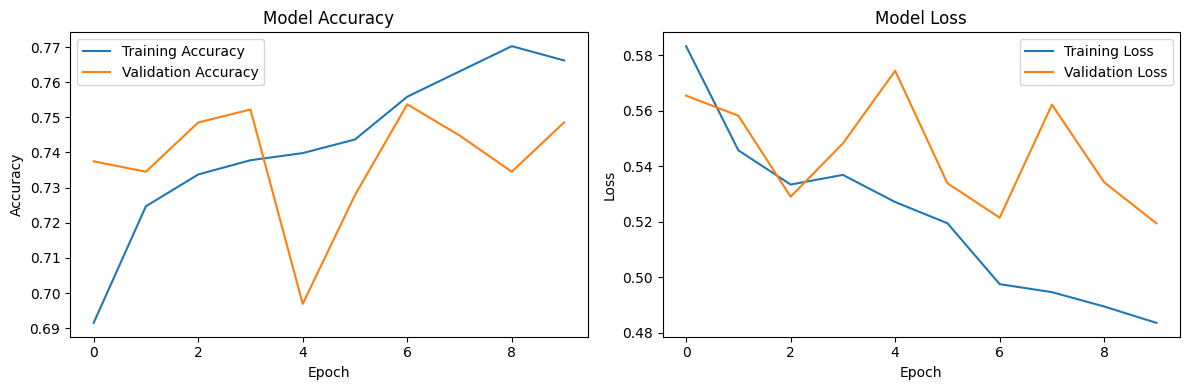

In [54]:
plots(history_2)

In [55]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1_2 = f1_score(y_val_labels_2, y_pred_labels_2, average='weighted')
precision_2 = precision_score(y_val_labels_2, y_pred_labels_2, average='weighted')
recall_2 = recall_score(y_val_labels_2, y_pred_labels_2, average='weighted')

print(f'F1 Score: {f1_2}')
print(f'Precision: {precision_2}')
print(f'Recall: {recall_2}')
# print(report_2)

F1 Score: 0.7494599514163338
Precision: 0.7530351074587933
Recall: 0.7485250737463127


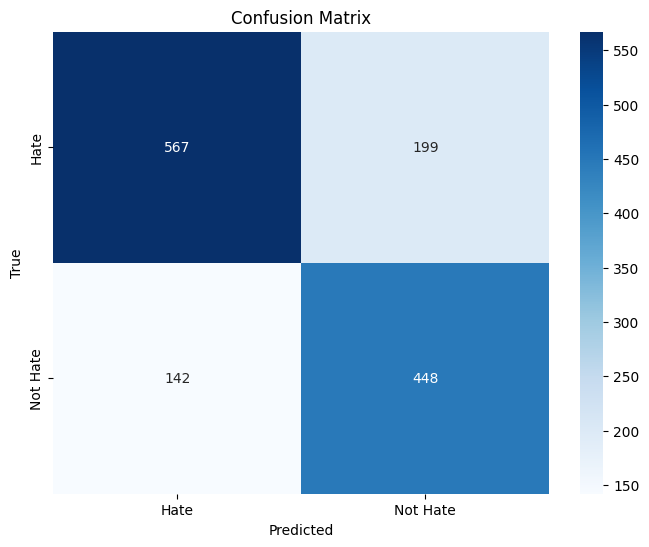

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix_2 = confusion_matrix(y_val_labels_2, y_pred_labels_2)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [58]:
history_3, model_3, y_val_labels_3, y_pred_labels_3=fn(X3,y3)
# Display the average classification report
# average_report_3 = f'Average Precision: {average_precision_3:.3f}\nAverage Recall: {average_recall_3:.3f}\nAverage F1-Score: {average_f1_score_3:.3f}'
# print(f'Average Classification Report Across {n_splits} Folds:\n{average_report_3}')

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.6496 - loss: 0.6370 - precision: 0.6496 - recall: 0.6496 - val_accuracy: 0.7109 - val_loss: 0.6068 - val_precision: 0.7109 - val_recall: 0.7109
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.7370 - loss: 0.5497 - precision: 0.7370 - recall: 0.7370 - val_accuracy: 0.7397 - val_loss: 0.5627 - val_precision: 0.7397 - val_recall: 0.7397
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.7528 - loss: 0.5255 - precision: 0.7528 - recall: 0.7528 - val_accuracy: 0.7323 - val_loss: 0.5416 - val_precision: 0.7323 - val_recall: 0.7323
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.7552 - loss: 0.5036 - precision: 0.7552 - recall: 0.7552 - val_accuracy: 0.7375 - val_loss: 0.5294 - val_precision: 0.7375 - val_recall: 0.7375
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - accuracy: 0.7636 - loss: 0.4881 - precision: 0.7636 - recall: 0.7636 - val_accuracy: 0.7176

In [59]:
model_3.save('/content/drive/MyDrive/NLP_Project/NLP/RNN_l3_Tamil_Binary_Classification.h5')

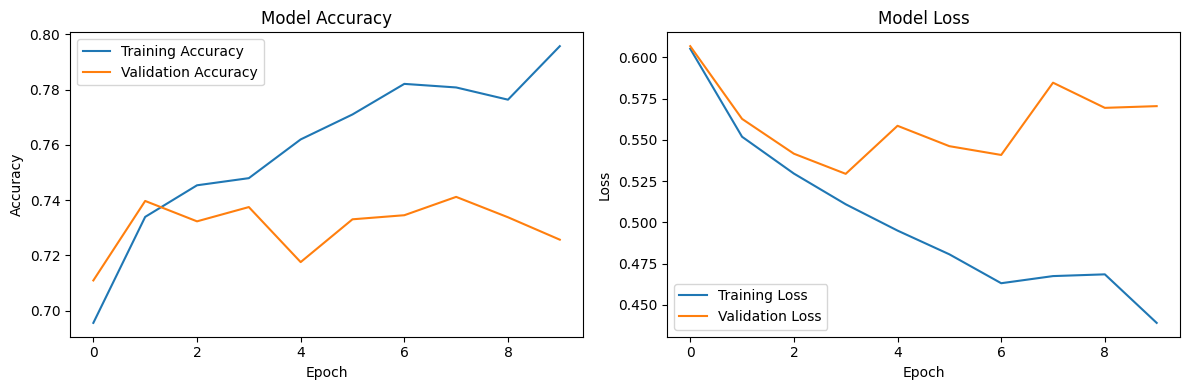

In [60]:
plots(history_3)

In [62]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

# Assuming you have `y_val_labels` and `y_pred_labels` as the true and predicted labels

# Compute F1 score, precision, and recall
f1_3 = f1_score(y_val_labels_3, y_pred_labels_3, average='weighted')
precision_3 = precision_score(y_val_labels_3, y_pred_labels_3, average='weighted')
recall_3 = recall_score(y_val_labels_3, y_pred_labels_3, average='weighted')

print(f'F1 Score: {f1_3}')
print(f'Precision: {precision_3}')
print(f'Recall: {recall_3}')
# print(report_3)

F1 Score: 0.7258314025645719
Precision: 0.7261537861843702
Recall: 0.7256637168141593


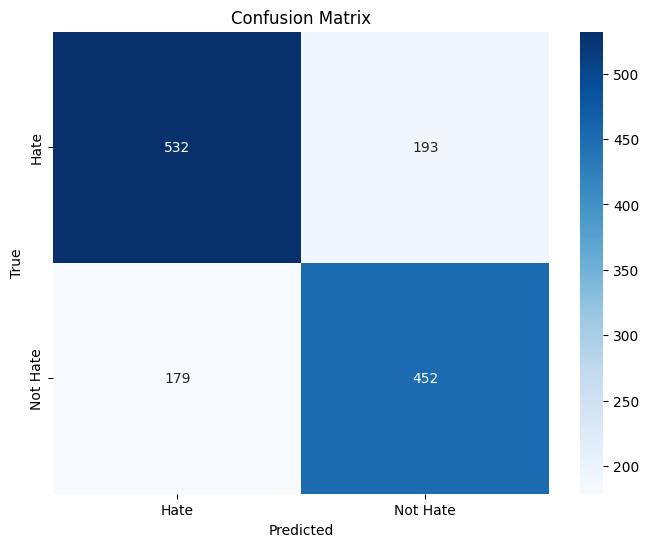

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true = true_labels
# y_pred = predicted_labels

# Generate the confusion matrix
conf_matrix_3 = confusion_matrix(y_val_labels_3, y_pred_labels_3)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Hate','Not Hate'],
            yticklabels=['Hate','Not Hate'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Testing on Unseen Data

In [64]:
# vv= pd.read_csv('/content/test_label1.csv')
vv_1= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l1.csv')
vv_2= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l2.csv')
vv_3= pd.read_csv('/content/drive/MyDrive/NLP_Project/NLP/testing/test_ta_l3.csv')


In [65]:
# # vv = vv[vv['language'] == 'tamil']
vv1=vv_1
vv2=vv_2
vv3=vv_3

In [66]:
from tensorflow import keras

model1 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/RNN_ICON_l1_Tamil_Binary_Classification.h5')
model2 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/RNN_ICON_l2_Tamil_Binary_Classification.h5')
model3 = keras.models.load_model('/content/drive/MyDrive/NLP_Project/NLP/RNN_ICON_l3_Tamil_Binary_Classification.h5')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/NLP_Project/NLP/RNN_ICON_l3_Tamil_Binary_Classification.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
vv_1['text'] = vv_1['text'].apply(lambda x: normalize_text(x))
vv_2['text'] = vv_2['text'].apply(lambda x: normalize_text(x))
vv_3['text'] = vv_3['text'].apply(lambda x: normalize_text(x))
# vv['text'] = vv['text'].apply(lambda x: normalize_text_2(x))
vv_1 = vv_1[['text']]
vv_2 = vv_2[['text']]
vv_3 = vv_3[['text']]
vv_1.columns = ['text']
vv_2.columns = ['text']
vv_3.columns = ['text']
vv_1

In [ ]:
# ## Word Pre-Processing ##
# import nltk
# import string
# import re

# ## Function to normalize text for pre-processing ##
# def normalize_text(text):
#   emoji_pattern = re.compile("["
#                               u"\U0001F600-\U0001F64F"  # emoticons
#                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
#                               u"\U0001F700-\U0001F77F"  # alchemical symbols
#                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
#                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
#                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
#                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
#                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
#                               u"\U00002702-\U000027B0"  # Dingbats
#                               u"\U000024C2-\U0001F251"
#                               "]+", flags=re.UNICODE)
#   text = text.lower()
#   text = re.sub('\[.*?\]', ' ', text)
#   text = re.sub('https?://\S+|www\.\S+', ' ', text)
#   text = re.sub('<.*?>+', ' ', text)
#   text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
#   text = re.sub('\n', ' ', text)
#   text = re.sub('\w*\d\w*', ' ', text)
#   text = re.sub('<handle replaced>', '', text)
#   text = emoji_pattern.sub(r'', text)
#   return text
# ## Apply the written function ##
# vv1['text'] = vv1['text'].apply(lambda x: normalize_text(x))
# vv1
# vv2['text'] = vv2['text'].apply(lambda x: normalize_text(x))
# vv2
# vv3['text'] = vv3['text'].apply(lambda x: normalize_text(x))
# vv3

In [67]:
######## Textual Features for Embedding ###################

sequence1 = tokenizer.texts_to_sequences(vv1.text)
sequence1 = pad_sequences(sequence1, padding='post', maxlen=max_seq_length)

sequence2 = tokenizer.texts_to_sequences(vv2.text)
sequence2 = pad_sequences(sequence2, padding='post', maxlen=max_seq_length)

sequence3 = tokenizer.texts_to_sequences(vv3.text)
sequence3 = pad_sequences(sequence3, padding='post', maxlen=max_seq_length)

In [68]:
sequence1 = tokenizer.texts_to_sequences(vv1['text']) # same tokenizer which is used on train data.
sequence1 = pad_sequences(sequence1,padding='post', maxlen = max_seq_length)

sequence2 = tokenizer.texts_to_sequences(vv2['text']) # same tokenizer which is used on train data.
sequence2 = pad_sequences(sequence2,padding='post', maxlen = max_seq_length)

sequence3 = tokenizer.texts_to_sequences(vv3['text']) # same tokenizer which is used on train data.
sequence3 = pad_sequences(sequence3,padding='post', maxlen = max_seq_length)

predictions1 = model_1.predict(sequence1)
classes1=np.argmax(predictions1,axis=1)

predictions2 = model_2.predict(sequence2)
classes2=np.argmax(predictions2,axis=1)

predictions3 = model_3.predict(sequence3)
classes3=np.argmax(predictions3,axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [69]:
predictions1



array([[0.25516725, 0.74483275],
       [0.2254626 , 0.7745374 ],
       [0.91996044, 0.08003955],
       ...,
       [0.22917405, 0.770826  ],
       [0.9594258 , 0.04057425],
       [0.29918492, 0.7008151 ]], dtype=float32)

In [70]:
predictions2



array([[0.25008252, 0.74991745],
       [0.40805227, 0.59194773],
       [0.92959887, 0.07040118],
       ...,
       [0.3979207 , 0.6020793 ],
       [0.74102706, 0.25897294],
       [0.64163417, 0.35836586]], dtype=float32)

In [71]:
predictions3

array([[0.31741157, 0.6825884 ],
       [0.57076496, 0.429235  ],
       [0.69560486, 0.30439517],
       ...,
       [0.7427015 , 0.2572985 ],
       [0.9316956 , 0.0683044 ],
       [0.9165653 , 0.08343476]], dtype=float32)

In [72]:
pred1 = np.argmax(predictions1, axis=1)
pred2 = np.argmax(predictions2, axis=1)
pred3 = np.argmax(predictions3, axis=1)

pred1



array([1, 1, 0, ..., 1, 0, 1])

In [73]:
pred2


array([1, 1, 0, ..., 1, 0, 0])

In [74]:
pred3

array([1, 0, 0, ..., 0, 0, 0])

In [75]:
col_lst = ['ta_a1', 'ta_a2', 'ta_a3', 'ta_a4', 'ta_a5', 'ta_a6']
for col in col_lst:
    vv1[col] = pd.to_numeric(vv1[col], errors='coerce')
    vv2[col] = pd.to_numeric(vv2[col], errors='coerce')
    vv3[col] = pd.to_numeric(vv3[col], errors='coerce')


vv1['label'] = vv1[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
vv2['label'] = vv2[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values
vv3['label'] = vv3[col_lst].max(axis=1, skipna=True).astype(int)  # skipna=True to ignore empty values

vv1['label'] = vv1['label'].astype(int)
vv2['label'] = vv2['label'].astype(int)
vv3['label'] = vv3['label'].astype(int)

vv1 = vv1[['label', 'text']]
vv2 = vv2[['label', 'text']]
vv3 = vv3[['label', 'text']]
vv1

true_1 = vv1["label"]
true_2 = vv2["label"]
true_3 = vv3["label"]
# print(true_)
y_test_1 = true_1.values
y_test_2 = true_2.values
y_test_3 = true_3.values
print(y_test_1)
print(len(y_test_1))

[0 1 0 ... 1 1 1]
1135


In [76]:
# Extract the predicted class labels
predictions1 = np.argmax(predictions1, axis=1)
predictions2 = np.argmax(predictions2, axis=1)
predictions3 = np.argmax(predictions3, axis=1)


In [77]:
ids = np.arange(1, len(y_test_1)+1)
result_df_1 = pd.DataFrame({'id': ids, 'prediction': predictions1, 'true': y_test_1})
# result_df_1

ids = np.arange(1, len(y_test_2)+1)
result_df_2 = pd.DataFrame({'id': ids, 'prediction': predictions2, 'true': y_test_2})
# result_df_2

ids = np.arange(1, len(y_test_3)+1)
result_df_3 = pd.DataFrame({'id': ids, 'prediction': predictions3, 'true': y_test_3})
result_df_3

,id,prediction,true
0,1,1,0
1,2,0,1
2,3,0,1
3,4,0,0
4,5,1,1
...,...,...,...
1130,1131,1,1
1131,1132,1,1
1132,1133,0,1
1133,1134,0,1


In [78]:
# Save the DataFrame to a CSV file
# result_df.to_csv('/content/Tamil_Task3_output.csv', index=False)
result_df_1.to_csv('/content/drive/MyDrive/NLP_Project/NLP/RNN_output_Tamil_l1.csv', index=False)
result_df_2.to_csv('/content/drive/MyDrive/NLP_Project/NLP/RNN_output_Tamil_l2.csv', index=False)
result_df_3.to_csv('/content/drive/MyDrive/NLP_Project/NLP/RNN_output_Tamil_l3.csv', index=False)

Similarly, the output for test_label3.csv is found by simply changing the path.


In [79]:
def compute_metrics(result_df, color):
    # Compute metrics
    accuracy = accuracy_score(result_df['true'], result_df['prediction'])
    f1 = f1_score(result_df['true'], result_df['prediction'], average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
    recall = recall_score(result_df['true'], result_df['prediction'], average='weighted')
    precision = precision_score(result_df['true'], result_df['prediction'], average='weighted')
    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    # print("Confusion Matrix:")
    # print(conf_matrix)

    conf_matrix = confusion_matrix(result_df['true'], result_df['prediction'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color, xticklabels=set(result_df['true']), yticklabels=set(result_df['true']))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Accuracy: 0.8317
F1 Score: 0.8309
Recall: 0.8317
Precision: 0.8305


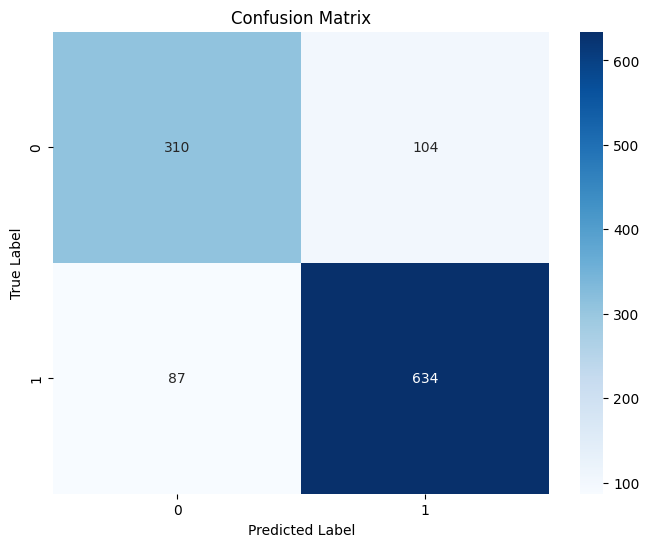

In [80]:
compute_metrics(result_df_1, "Blues")

Accuracy: 0.6837
F1 Score: 0.7063
Recall: 0.6837
Precision: 0.8346


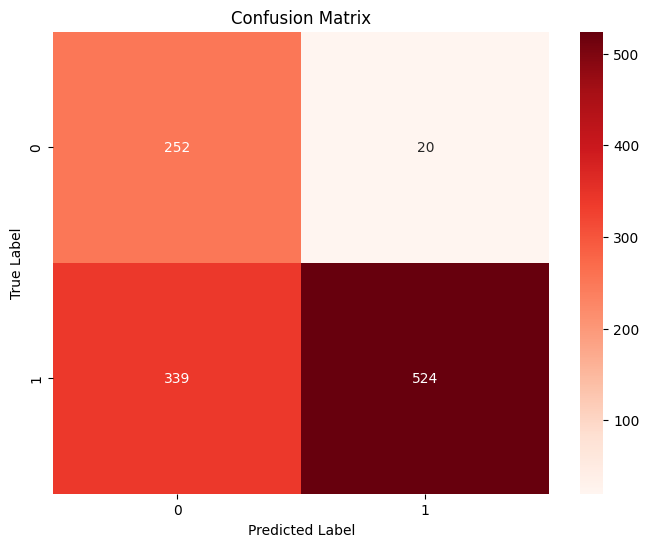

In [81]:
compute_metrics(result_df_2, "Reds")

Accuracy: 0.6881
F1 Score: 0.7081
Recall: 0.6881
Precision: 0.8514


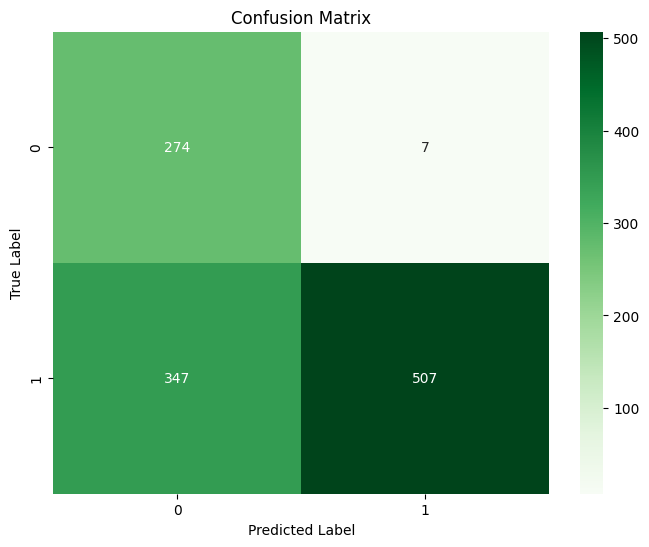

In [82]:
compute_metrics(result_df_3, "Greens")